<a href="https://colab.research.google.com/github/Abdulhamid97Mousa/Hierarchical_Diagnosis_BearingFaults_B_CNN/blob/main/Copy_of_pyTorch_Scratch_BranchedCNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optimas 
import numpy as np

In [2]:
# setting the device for workout

print(torch.cuda.is_available())
device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

True


device(type='cuda', index=0)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Size of our training set: 60000
Size of our test set: 10000
Bincounts: tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])
Input tensor shape: torch.Size([1, 1, 28, 28])
Labels shape: torch.Size([1])


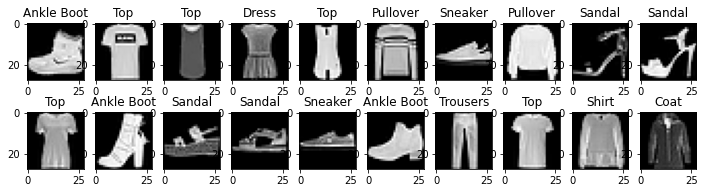

In [3]:
# importing the dataset 
import torchvision.transforms as transform
import matplotlib.pyplot as plt

train_dataset= torchvision.datasets.FashionMNIST(root= 'data/', train= True, download= True, transform= transform.ToTensor())
test_dataset= torchvision.datasets.FashionMNIST(root= 'data/', train= False, download= True, transform= transform.ToTensor())

batch_size= 100
train_loader= torch.utils.data.DataLoader(dataset= train_dataset, batch_size= batch_size, shuffle= True)
test_loader= torch.utils.data.DataLoader(dataset= test_dataset, batch_size= batch_size, shuffle= True)


# about our dataset
print("Size of our training set:", len(train_dataset))
print("Size of our test set:", len(test_dataset))
print("Bincounts:", train_dataset.targets.bincount());

mapping = {
    0:'Top', 1:'Trousers', 2:'Pullover', 3:'Dress', 4:'Coat'
    ,5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle Boot'
}

display_loader= torch.utils.data.DataLoader(dataset= train_dataset, batch_size= 1)
batch= next(iter(display_loader))
images, labels= batch
print("Input tensor shape:", images.shape)
print("Labels shape:", labels.shape)

fig= plt.figure(figsize= (12, 3))
for i, batch in enumerate(display_loader, start= 1):
  images, labels= batch
  ax= fig.add_subplot(2, 10, i)  
  ax.imshow(images.reshape(28, 28), cmap= 'gray')
  ax.set_title(mapping[labels.item()])
  if i >= 20:
    break 
plt.show()




In [13]:
class Net(nn.Module):
    def __init__(self, num_classes= 10):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),
            # nn.init.kaiming_normal_(),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # nn.Dropout2d(0.5),
            nn.MaxPool2d(kernel_size= 2, stride= 2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            # nn.init.kaiming_normal_(),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # nn.Dropout2d(0.5),
            nn.MaxPool2d(kernel_size= 2, stride= 2),
            # nn.Flatten()

        )
        self.conv1flatten= nn.Flatten()

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
            # nn.init.kaiming_normal_(),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # nn.Dropout2d(0.5),
            nn.MaxPool2d(kernel_size= 2, stride= 2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2),
            # nn.init.kaiming_normal_(),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # nn.Dropout2d(0.5),
            nn.MaxPool2d(kernel_size= 2, stride= 2),
            # nn.Flatten()

        )        
        self.conv2flatten= nn.Flatten()

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=9),
            # nn.init.kaiming_normal_(),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # nn.Dropout2d(0.5),
            nn.MaxPool2d(kernel_size= 2, stride= 2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=7),
            # nn.init.kaiming_normal_(),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # nn.Dropout2d(0.5),
            nn.MaxPool2d(kernel_size= 2, stride= 2),
            # nn.Flatten()

        )        
        
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=1952, out_features=720), # 12 * 4 * 4 
            # nn.init.kaiming_normal_(),
            # nn.BatchNorm1d(1440),
            nn.ReLU(),
            # nn.Dropout(0.5)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=720, out_features=360),
            # nn.init.kaiming_normal_(),
            # nn.BatchNorm1d(720),
            nn.ReLU(),
            # nn.Dropout(0.5)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=360, out_features=180),
            # nn.init.kaiming_normal_(),
            # nn.BatchNorm1d(360),
            nn.ReLU(),
            # nn.Dropout(0.5)
        )
        self.out = nn.Sequential(
            nn.Linear(in_features=180, out_features= num_classes),
            # nn.init.kaiming_normal_(),
        )
        

    def forward(self, t):
      # (1) input layer
      t = t
      print("t = t", t.shape)
      t1= self.conv1(t)
      print('self.conv1 =========== t1', t1.shape)
      t2= self.conv2(t)
      print('self.conv2 =========== t2', t2.shape)
      t3= self.conv3(t)
      print('self.conv3 =========== t3', t3.shape)
      t= torch.cat((self.conv1flatten(t1), self.conv2flatten(t2)), dim= 1)
      print('t= torch.cat((self.conv1flatten(t1), self.conv2flatten(t2)), dim=1)', t.shape)
      t= self.fc1(t)
      print('self.fc1(t)', t.shape)
      t= self.fc2(t)
      print('self.fc2(t)', t.shape)
      t= self.fc3(t)
      print('self.fc3(t)', t.shape)
      t= self.out(t)
      print('self.out(t)', t.shape)

      return t3, t

In [14]:
num_classes= 10
model= Net(num_classes).to(device)


In [15]:
model

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv1flatten): Flatten(start_dim=1, end_dim=-1)
  (conv2): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [16]:
# testing out model without training
sample= next(iter(train_dataset))
image, label= sample
print("Shape of the input image:", image.shape)

layer, pred= model(image.unsqueeze(0).to(device))  
print("Prediction:", pred)
print("Expected:", mapping[label], "| Prediction:", mapping[pred.argmax().item()])

def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

Shape of the input image: torch.Size([1, 28, 28])
t = t torch.Size([1, 1, 28, 28])
self.conv1 =========== t1 torch.Size([1, 32, 5, 5])
self.conv2 =========== t2 torch.Size([1, 32, 6, 6])
self.conv3 =========== t3 torch.Size([1, 32, 2, 2])
t= torch.cat((self.conv1flatten(t1), self.conv2flatten(t2)), dim=1) torch.Size([1, 1952])
self.fc1(t) torch.Size([1, 720])
self.fc2(t) torch.Size([1, 360])
self.fc3(t) torch.Size([1, 180])
self.out(t) torch.Size([1, 10])
Prediction: tensor([[-0.0003,  0.0951, -0.0413, -0.0060,  0.0019,  0.0712, -0.0079, -0.0337,
         -0.0429,  0.0718]], device='cuda:0', grad_fn=<AddmmBackward0>)
Expected: Ankle Boot | Prediction: Trousers


In [17]:
print(model.conv2[0])
print(layer.shape)


Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
torch.Size([1, 32, 2, 2])


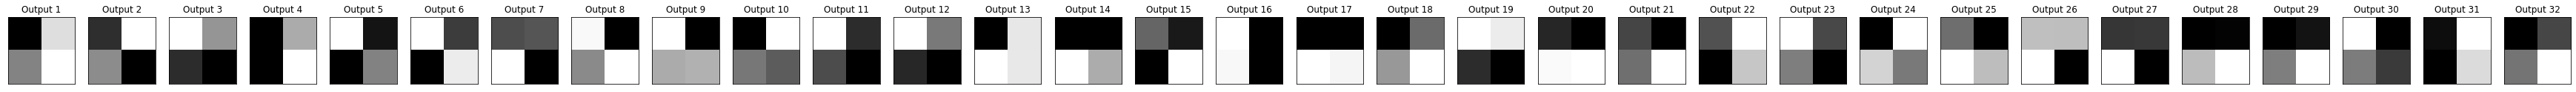

In [18]:
# helper function for visualizing the output of a given layer
# default number of filters is 4
def viz_layer(layer, n_filters= 32):
    fig = plt.figure(figsize=(62, 20))
    
    for i in range(n_filters):
        ax = fig.add_subplot(1, n_filters, i+1, xticks=[], yticks=[])
        # grab layer outputs
        ax.imshow(np.squeeze(layer[0,i].data.numpy()), cmap='gray')
        ax.set_title('Output %s' % str(i+1))
viz_layer(layer.cpu())

In [19]:
# Pytorch
import torch
from torch import nn
from torch.nn import functional as F
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
from torch.nn.modules.loss import CrossEntropyLoss

# network = model
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(50):

  total_loss = 0
  total_correct = 0

  for batch in train_loader: # Get Batch

      images, labels = batch 

      images= images.to(device)
      labels= labels.to(device)

      layer, preds = model(images) # Pass Batch
      loss = f.cross_entropy(preds, labels) # Calculate Loss

      optimizer.zero_grad()
      loss.backward() # Calculate Gradients
      optimizer.step() # Update Weights

      total_loss += loss.item()
      total_correct += get_num_correct(preds, labels)
      
  print(
      "epoch:", epoch, 
      "total_correct:", total_correct, 
      "loss:", total_loss
  )

t = t torch.Size([100, 1, 28, 28])
self.conv1 =========== t1 torch.Size([100, 32, 5, 5])
self.conv2 =========== t2 torch.Size([100, 32, 6, 6])
self.conv3 =========== t3 torch.Size([100, 32, 2, 2])
t= torch.cat((self.conv1flatten(t1), self.conv2flatten(t2)), dim=1) torch.Size([100, 1952])
self.fc1(t) torch.Size([100, 720])
self.fc2(t) torch.Size([100, 360])
self.fc3(t) torch.Size([100, 180])
self.out(t) torch.Size([100, 10])
t = t torch.Size([100, 1, 28, 28])
self.conv1 =========== t1 torch.Size([100, 32, 5, 5])
self.conv2 =========== t2 torch.Size([100, 32, 6, 6])
self.conv3 =========== t3 torch.Size([100, 32, 2, 2])
t= torch.cat((self.conv1flatten(t1), self.conv2flatten(t2)), dim=1) torch.Size([100, 1952])
self.fc1(t) torch.Size([100, 720])
self.fc2(t) torch.Size([100, 360])
self.fc3(t) torch.Size([100, 180])
self.out(t) torch.Size([100, 10])
t = t torch.Size([100, 1, 28, 28])
self.conv1 =========== t1 torch.Size([100, 32, 5, 5])
self.conv2 =========== t2 torch.Size([100, 32, 6, 6])
s

KeyboardInterrupt: ignored

In [ ]:
# Pytorch
import torch
from torch import nn
from torch.nn import functional as F
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
from torch.nn.modules.loss import CrossEntropyLoss

In [ ]:
import pandas as pd

def loss_batch(model, loss_func, xb, yb, opt=None):
    
    '''
        Parameter:
            model: Module
                Your neural network model
            loss_func: Loss
                Loss function, e.g. CrossEntropyLoss()
            xb: Tensor
                One batch of input x
            yb: Tensor
                One batch of true label y
            opt: Optimizer
                Optimizer, e.g. SGD()
        
        Return:
            loss.item(): Python number
                Loss of the current batch
            len(xb): Int
                Number of examples of the current batch
            pred: ndarray
                Predictions (class with highest probability) of the minibatch 
                input xb
    '''
    out = model(xb)
    # print('out.shape', out.shape)
    pred = torch.argmax(out, dim=1).cpu()
    # print("pred.shape", pred.shape)
    loss = loss_func(out, yb)
    # print("loss", loss)
    

    if opt is not None:
        
        loss.backward()
        opt.step()
        opt.zero_grad()

    
    return loss.item(), len(xb), pred

def fit(epochs, model, loss_func, opt, train_dl, valid_dl, train_metric=False, schedular=None):
    '''
        Train the NN model and return the model at the final step.
        Lists of the training and validation losses at each epochs are also 
        returned.

        Parameter:
            epochs: int
                Number of epochs to run.
            model: Module
                Your neural network model
            loss_func: Loss
                Loss function, e.g. CrossEntropyLoss()
            opt: Optimizer
                Optimizer, e.g. SGD()
            train_dl: DataLoader
                Dataloader of the training set.
            valid_dl: DataLoader
                Dataloader of the validation set.
            train_metric: Bool
                Default is False. If False, the train loss and accuracy will be
                set to 0.
                If True, the loss and accuracy of the train set will also be 
                computed.

        Return:
            model: Module
                Trained model.
            metrics: DataFrame
                DataFrame which contains the train and validation loss at each
                epoch.
    '''
    print(
        'EPOCH', '\t', 
        'Train Loss', '\t',
        'Val Loss', '\t', 
        'Train Acc', '\t',
        'Val Acc', '\t')
    # Initialize dic to store metrics for each epoch.
    metrics_dic = {}
    metrics_dic['train_loss'] = []
    metrics_dic['train_accuracy'] = []
    metrics_dic['val_loss'] = []
    metrics_dic['val_accuracy'] = []

    # early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(epochs):
        # Train
        model.train()
        train_loss = 0.0
        train_accuracy = 0.0
        num_examples = 0
        
        
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            #print("xb, yb shapes", xb.shape, yb.shape)
            #print("model(xb).shape", model(xb).shape)
            # yb = yb.view(1, -1)
            loss, batch_size, pred = loss_batch(model, loss_func, xb, yb, opt)
            if train_metric == False:
                train_loss += loss
                num_examples += batch_size
            
        # Validate
        model.eval()
        with torch.no_grad():
            val_loss, val_accuracy, _ = validate(model, valid_dl, loss_func)
            
            if train_metric:
                train_loss, train_accuracy, _ = validate(model, train_dl, loss_func)
                ##########################
                schedular.step()
                ##########################
            else:
                train_loss = train_loss / num_examples

        metrics_dic['val_loss'].append(val_loss)
        metrics_dic['val_accuracy'].append(val_accuracy)
        metrics_dic['train_loss'].append(train_loss)
        metrics_dic['train_accuracy'].append(train_accuracy)
        
        print(
            f'{epoch} \t', 
            f'{train_loss:.05f}', '\t',
            f'{val_loss:.05f}', '\t', 
            f'{train_accuracy:.05f}', '\t'
            f'{val_accuracy:.05f}', '\t')
        
    metrics = pd.DataFrame.from_dict(metrics_dic)

    return model, metrics
    
def validate(model, dl, loss_func):
    total_loss = 0.0
    total_size = 0
    predictions = []
    y_true = []
    for xb, yb in dl: 
        xb, yb = xb.to(device), yb.to(device)

        loss, batch_size, pred = loss_batch(model, loss_func, xb, yb)
        total_loss += loss*batch_size
        total_size += batch_size
        predictions.append(pred)
        y_true.append(yb.cpu().numpy())
    mean_loss = total_loss / total_size
    
    predictions = np.concatenate(predictions, axis=0)
    y_true = np.concatenate(y_true, axis=0)
    accuracy = np.mean((predictions == y_true))

    return mean_loss, accuracy, (y_true, predictions)

In [ ]:
from torch.optim import lr_scheduler
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model= Net(num_classes).to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.01)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1, verbose=True)

# num_epochs 
epochs = 35

Adjusting learning rate of group 0 to 1.0000e-02.


In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
test_loader= torch.utils.data.DataLoader(dataset= test_dataset, batch_size= 100, shuffle= True)

In [ ]:
import time 
tic = time.time()
## Train
epochs = 30
model, metrics = fit(epochs, model, criterion, optimizer_ft, train_loader, test_loader, train_metric=True, schedular=exp_lr_scheduler)
toc = time.time()
print(toc-tic)

EPOCH 	 Train Loss 	 Val Loss 	 Train Acc 	 Val Acc 	


TypeError: ignored

In [ ]:
import torch.optim
from torch.nn.modules.loss import CrossEntropyLoss
import torch.nn.functional as f
# network = model
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(50):

  total_loss = 0
  total_correct = 0

  for batch in train_loader: # Get Batch

      images, labels = batch 

      images= images.to(device)
      labels= labels.to(device)


      out = model(images)
      pred = torch.argmax(out, dim=1).cpu()
      # preds = model(images) # Pass Batch
      loss = f.cross_entropy(pred, labels) # Calculate Loss

      optimizer.zero_grad()
      loss.backward() # Calculate Gradients
      optimizer.step() # Update Weights

      total_loss += loss.item()
      total_correct += get_num_correct(preds, labels)
      
  print(
      "epoch:", epoch, 
      "total_correct:", total_correct, 
      "loss:", total_loss
  )

TypeError: ignored

In [ ]:
model.conv1[0].weight

Parameter containing:
tensor([[[[-1.7990e-02,  3.0842e-02, -2.3291e-02, -1.4474e-02,  5.0704e-02],
          [-3.4958e-02, -4.6800e-02,  4.6592e-02, -5.3254e-02,  3.8517e-02],
          [ 9.9543e-02, -2.8296e-02, -1.3046e-01,  2.0390e-02,  1.8859e-01],
          [ 2.1782e-01, -9.8338e-02,  1.1958e-01,  1.1983e-01, -1.6653e-01],
          [-7.8397e-02,  1.6148e-01,  7.9670e-02, -1.8538e-01, -6.2991e-01]]],


        [[[-6.1964e-01, -1.5281e+00, -1.4026e+00, -1.0540e+00, -4.5047e-01],
          [ 6.0781e-02, -4.3848e-01, -4.8577e-02,  1.7695e-01,  9.7682e-02],
          [ 2.5847e-01,  1.3066e-01, -4.5324e-03, -2.1098e-01,  7.3244e-02],
          [ 2.1764e-02, -1.2442e-01, -4.0748e-02,  2.6418e-03, -3.4058e-02],
          [ 2.5583e-01,  6.6850e-03, -6.9963e-02, -5.8302e-02, -1.7086e-02]]],


        [[[-1.9790e-02, -1.2373e-01,  1.8241e-01,  5.3283e-02,  4.6942e-03],
          [-1.7193e-01,  1.7195e-01,  2.3836e-02, -2.1343e-02, -2.8478e-02],
          [ 4.5959e-03, -4.5776e-02,  1.6217e-

In [ ]:
model.conv2[0].weight

Parameter containing:
tensor([[[[ 3.6011e-01, -9.5651e-02, -3.0078e-01],
          [ 1.1491e-01,  5.3771e-02,  9.2828e-02],
          [-3.1269e-01,  2.4944e-01, -1.3578e-01]]],


        [[[ 4.0366e-01, -3.7802e-01,  3.3622e-02],
          [ 7.2465e-02,  2.3085e-01, -2.2581e-01],
          [-3.0494e-01,  7.9709e-02,  1.0205e-01]]],


        [[[ 3.0099e-01, -3.0518e-01,  7.1098e-02],
          [ 6.1099e-02,  2.9514e-01, -2.9776e-01],
          [-2.7994e-01,  1.2829e-01,  9.5965e-02]]],


        [[[-1.4330e+00, -2.0537e+00, -3.5803e-01],
          [ 1.3617e-01, -3.0113e-01,  1.7119e-02],
          [-8.6629e-02,  8.2718e-02,  1.7764e-01]]],


        [[[-7.4855e-01, -8.5688e-01, -4.1994e-01],
          [-2.6698e-01, -1.7029e+00, -1.5763e+00],
          [ 7.9813e-02, -3.5820e-02, -7.6342e-02]]],


        [[[-1.0839e+00, -2.0346e+00, -3.2765e-01],
          [-1.1894e+00, -6.2630e-01,  1.3458e-01],
          [ 1.1373e-02, -1.6681e-01,  1.7190e-01]]],


        [[[-8.1927e-02, -1.9978e-01,